In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Supervised Machine Learning - 

In the last notebook (Notebook2), we compared various classifiers against the time series data and found four classifiers which yielded efficient results. In this notebook focusses on tuning the hyperparameters of four classifiers. 

* Support Vector Machines
* Random Forest
* K-Nearest Neighbours
* Neural Network
<br>
<br>



__Methodology__ - The data first undergoes PCA transformation to reduce the dimensionality. Then, for each classifier, we perform training with grid search and cross validation to find the optimal choice of parameters. Each classifier is trained with varying PCA components and optimization over each hyperparameter. Overfitting is checked by comparing the training scores with cross validation scores.  



In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab as P
import time, glob, os, math
from matplotlib import cm 
from CommonFunctions import *

from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

#Classifiers
from sklearn.tree import DecisionTreeClassifier as DT, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV



import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rc('lines', linewidth=2, color='r')
mpl.rc('font', size=16)
mpl.rc('axes', labelsize=16, grid=True)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('legend', fontsize=14)


import warnings
warnings.filterwarnings("ignore")



In [2]:
random_state = 100

In [3]:
os.chdir('/localdata2/bkhamesra3/MachineLearning/GW-MLClassification/Data/')


## Building Data

Collect all waveforms and spin-type. Convert the spin-type category from string to numerical labels. 

In [4]:
#Loading the Dataset

waveform_collection = []
GT_filepaths = sorted(glob.glob("FilteredData/GT*.txt"))
SXS_filepaths = sorted(glob.glob("FilteredData/SXS*.txt"))


for wf_file_gt in GT_filepaths:
    
    metadata_file = os.path.join('Metadata','Metadata_'+os.path.basename(wf_file_gt).split('.txt')[0]+'.csv')
    wf = waveform(wf_file_gt, metadata_file)
    waveform_collection.append(wf)
    
for wf_file_sxs in SXS_filepaths:
    
    metadata_file = os.path.join('Metadata','Metadata_'+os.path.basename(wf_file_sxs).split('.txt')[0]+'.csv')
    wf = waveform(wf_file_sxs, metadata_file)
    waveform_collection.append(wf)
    


In [25]:
#Concatenate plus and cross polarization
def concat_wf_timedata(wf):
    '''Concatenate the real and imaginary components of waveform in time domain'''
    #print(wf.name, wf.spin_type)
    data = np.concatenate((wf.hp, wf.hx))
    
    return data

def concat_wf_freqdata(wf):
    '''Concatenate the plus and cross polarization components of waveform in frequency domain'''
    #print(wf.name, wf.spin_type)
    data = np.concatenate((np.absolute(wf.hf_plus)[wf.freq>0], np.absolute(wf.hf_cross)[wf.freq>0]))
    
    return data


waveform_collection  = np.asarray(waveform_collection)

waveform_nospin  = []
waveform_alignspin  = []
waveform_precess  = []

#print(le.inverse_transform(y))
for wf in waveform_collection:
    if wf.spin_type=='Precessing':
        waveform_precess.append(wf)
    elif wf.spin_type=='NonSpinning':
        waveform_nospin.append(wf)
    else: 
        waveform_alignspin.append(wf)

        
wf_precess_select50 =  np.random.choice(waveform_precess, size=50, replace=False)

wf_collection_short = np.asarray(waveform_nospin + waveform_alignspin + list(wf_precess_select50))


# waveform_data_ht - each row represents concatenated data corresponding to one waveform in order (t, real, imag)
waveform_data_ht = list(map(concat_wf_timedata, wf_collection_short))
waveform_data_ht = np.matrix(waveform_data_ht)

# waveform_data_hf - each row represents concatenated data corresponding to one waveform in order (f, FT(real), FT(imag))
waveform_data_hf = list(map(concat_wf_freqdata, wf_collection_short))
waveform_data_hf = np.matrix(waveform_data_hf)

# Output
y = [wf.spin_type for wf in wf_collection_short]

# Convert spin labels from string to numbers
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)



In [26]:
#Inspecting the data

cls_uniq = np.unique(y_numeric)
npts_clas0 = np.size(np.where(y_numeric==cls_uniq[0]))
npts_clas1 = np.size(np.where(y_numeric==cls_uniq[1]))
npts_clas2 = np.size(np.where(y_numeric==cls_uniq[2]))

cls_uniq = le.inverse_transform(cls_uniq)
print('Total number of points = %d'%np.size(y_numeric))
print('Total {} cases = {}'.format(cls_uniq[0], npts_clas0))
print('Total {} cases = {}'.format(cls_uniq[1], npts_clas1))
print('Total {} cases = {}'.format(cls_uniq[2], npts_clas2))

Total number of points = 151
Total AlignedSpins cases = 55
Total NonSpinning cases = 46
Total Precessing cases = 50


##  Logistic Regression  Optimization

Let's try we can optimize logistic regression. We can start with the default parameters with 2 PCA components and training size of 0.85 (based on previous analysis). We follow the same strategy - 

* Standardize the data with zero mean and unit variance
* Perform a PCA
* Apply Logistic regression

For the default case, we see the training and CV scores lie close to 40% while test scores are extremely low. Looking at the results, logistic regression is clearly labeling all the points as aligned spins. This can be seen from decision boundary where the predicted boundaries are completely off. 

__Optimization Methods__ - 
1. PCA Variation - Variations in PCA components from 2 to 60
2. Grid Search - Variations over tolerance (sets the stopping criteria), regularization strength, class weight and solver. 


__Results__-
1. Results change significantly with Training, Test and CV scores reaching upto 60-70%. The classifier now attempts to distinguish between all three classes even with just 2 PCA components
2. Primary modifications which improved the results include using balanced weight with higher regularization strength (or smaller values of 'C').
3. Even with improved results, Logistic Regression is clearly not a good method as accuracies are extremely low. This is simply due to inherent non-linear nature of the data which can be clearly gauged from distribution of data in the decision surface plots. 

In [44]:
#%%time


#Finding optimal training data size    
pca_num  = np.array((2,5,10,20))
trainsize=0.8
rs = random_state

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

print("Training Data after standardization - Mean = {:.4g}, Standard Deviation = {:.4g}".format(data_train.mean(), data_train.std()))
print("Test Data after standardization - Mean = {:.4g}, Standard Deviation = {:.4g} \n\n".format(data_test.mean(), data_test.std()))

print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")
print("-"*100)

score_train, score_test, cv_scores = np.zeros((3, len(pca_num)))

#plt.figure(figsize=(10,6))
for i, pca_comp in enumerate(pca_num):
    
    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    pca_time = time.time() 
    
    
    #Logistic Regression with default parameters
    clf = LogisticRegression( max_iter=1000, random_state=rs)  
    clf.fit(data_train_pca, y_train)
    
    #Compute the cross validation, training and test scores
    score_train[i] = clf.score(data_train_pca, y_train)
    cv_scores[i] = cross_val_score(clf, data_train_pca, y_train, cv=5).mean()
    score_test[i] = clf.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(clf.predict(data_test_pca))
    
    
    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train[i], \
                                             cv_scores[i], score_test[i]))
    #print("Classes predicted using {} PCA components by Logistic regression = {}".format(pca_comp, le.inverse_transform(clf_class_predictions)))
    #print("Logistic Regression with default settings and 2 PCA components - ")
    #print("\t Training Score = {:.4g}".format(score_train))
    #print("\t CV Score       = {:.4g}".format(cv_scores.mean()))
    #print("\t Test Score = {:.4g}".format(score_test))
    
    
lr_rawscores_dict = {'pca':pca_num, 'train_score':score_train, 'cv_score': cv_scores, 'test_score':score_test}


Training Data after standardization - Mean = 1.403e-18, Standard Deviation = 1
Test Data after standardization - Mean = 0.005719, Standard Deviation = 0.9794 


# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
----------------------------------------------------------------------------------------------------
 2 	 	 	 2 		 0.37 		 0.37 		 0.19
 5 	 	 	 3 		 0.52 		 0.48 		 0.29
 10 	 	 	 3 		 0.56 		 0.42 		 0.29
 20 	 	 	 3 		 0.63 		 0.45 		 0.29


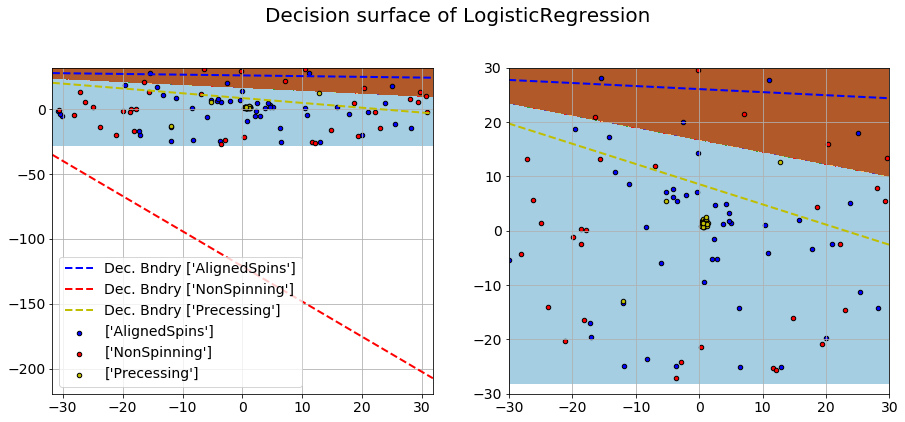

In [28]:
#Plot decision Surface

#Train classifier - 
data_train_pca, pca_train_time = func_PCA(2, data_train, rs)
pca_time = time.time() 


#Logistic Regression with default parameters
clf = LogisticRegression( max_iter=1000, random_state=rs)  
clf.fit(data_train_pca, y_train)
    

# Create a mesh to plot in
h = .1# step size in the mesh
x_min, x_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
y_min, y_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

fig =  plt.figure(figsize=(15,6))

plt.subplot(121)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
#plt.axis('tight')
         
plt.subplot(122)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
fig.suptitle("Decision surface of LogisticRegression", fontsize=20, y=1.02 )
plt.axis('tight')


# Plot also the training points
colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y_train == i)
    plt.subplot(121)
    plt.scatter(data_train_pca[idx, 0], data_train_pca[idx, 1], c=color, cmap=plt.cm.Paired,\
                edgecolor='black', s=20, label=le.inverse_transform(np.asarray([i])))
    
    
    plt.subplot(122)
    plt.scatter(data_train_pca[idx, 0], data_train_pca[idx, 1], c=color, cmap=plt.cm.Paired,\
                edgecolor='black', s=20, label=le.inverse_transform(np.asarray([i])))
   
# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_

def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
             ls="--", color=color, label='Dec. Bndry %s'%le.inverse_transform(np.asarray([c])))

for i, color in zip(clf.classes_, colors):
    plt.subplot(121)
    plot_hyperplane(i, color)
    plt.legend()
    
    plt.subplot(122)
    plot_hyperplane(i, color)
    #plt.legend()
    
plt.xlim(-30,30)
plt.ylim(-30,30)

plt.show()

In [45]:
#Logistic Regression Optimization with gridsearch and PCA components


clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=rs)  
params={'C':10.**np.arange(-3,1,1),'solver':['newton-cg', 'lbfgs','sag', 'saga'], 'tol':[1e-1, 1e-2,1e-3,1e-4], 'class_weight':[None, 'balanced']}
verbose=1 

#Finding optimal training data size    
pca_num  = np.array((2,5,10,20))
trainsize=0.8
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)


score_train, score_test, cv_scores = np.zeros((3, len(pca_num)))

#standardization_time = time.time() 
for i, pca_comp in enumerate(pca_num):

    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    
    pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)
    
    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train[i] = search.score(data_train_pca, y_train)
    cv_scores[i] = cross_val_score(search, data_train_pca, y_train, cv=5).mean()
    score_test[i] = search.score(data_test_pca,y_test)
    #print(score_train[i], cv_scores[i], score_test[i])
    if pca_comp==2:
        grid_params = search.best_params_
        
    print("Number of PCA components = {}, LR best parameters = {}".format(pca_comp, search.best_params_))

lr_optscores_dict = {'pca':pca_num, 'train_score':score_train, 'cv_score': cv_scores, 'test_score':score_test}

    



Number of PCA components = 2, LR best parameters = {'C': 1.0, 'class_weight': 'balanced', 'solver': 'sag', 'tol': 0.1}
Number of PCA components = 5, LR best parameters = {'C': 0.001, 'class_weight': None, 'solver': 'newton-cg', 'tol': 0.1}
Number of PCA components = 10, LR best parameters = {'C': 1.0, 'class_weight': 'balanced', 'solver': 'sag', 'tol': 0.1}
Number of PCA components = 20, LR best parameters = {'C': 0.01, 'class_weight': None, 'solver': 'saga', 'tol': 0.1}


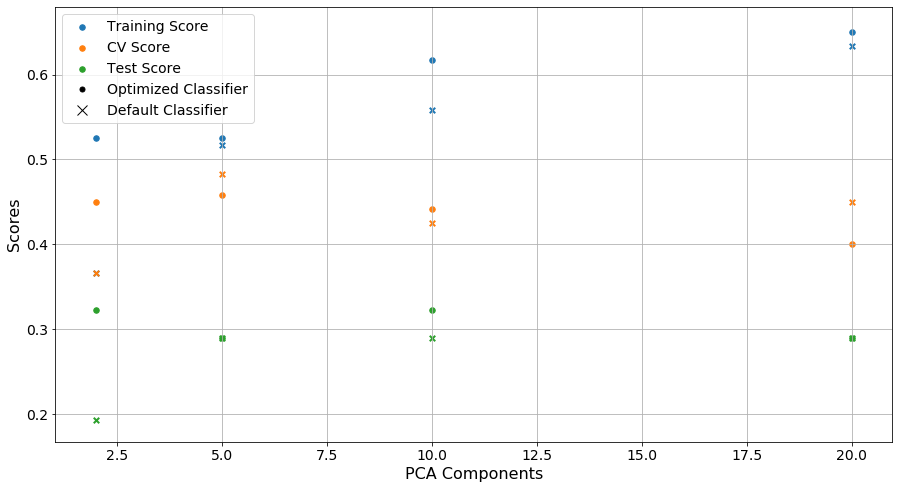

In [46]:
#Plots
plt.figure(figsize=(15,8))

train_plot = plt.scatter(lr_optscores_dict['pca'], lr_optscores_dict['train_score'], marker='o',  s=30, c='C0', label='Training Score')
cv_plot    = plt.scatter(lr_optscores_dict['pca'], lr_optscores_dict['cv_score'], marker='o',  s=30, c='C1', label='CV Score')
test_plot  =plt.scatter(lr_optscores_dict ['pca'], lr_optscores_dict['test_score'], marker='o', s=30, c='C2', label='Test Score')

plt.scatter(lr_rawscores_dict['pca'], lr_rawscores_dict['train_score'], marker='x', s=30, c='C0')
plt.scatter(lr_rawscores_dict['pca'], lr_rawscores_dict['cv_score'], marker='x', s=30, c='C1')
plt.scatter(lr_rawscores_dict['pca'], lr_rawscores_dict['test_score'], marker='x', s=30, c='C2')

opt_params = mlines.Line2D([], [], color='k', marker='.', linestyle='None',
                          markersize=10, label='Optimized Classifier')
def_params = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Default Classifier')

plt.xlabel('PCA Components')
plt.ylabel('Scores')
plt.legend(handles = [train_plot, cv_plot, test_plot, opt_params, def_params])
plt.show()
plt.close()
   

Logistic Regression with default settings and 2 PCA components - 
	 Training Score = 0.525
	 CV Score       = 0.4667
	 Test Score = 0.6129


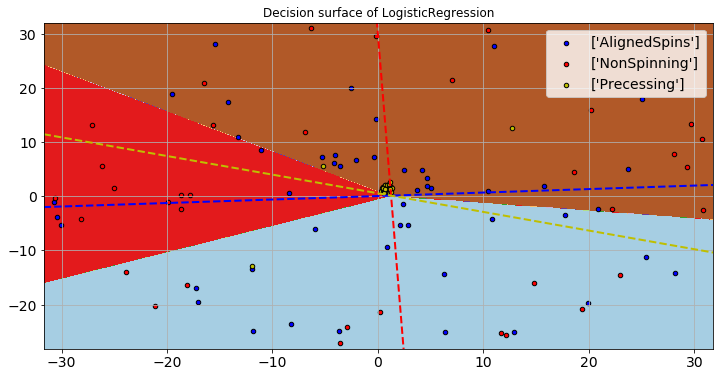

In [47]:
#Decision boundaries for Logistic Regression with optimized parameters ( 2 PCA components)

clf_lr = LogisticRegression( max_iter=1000, C=grid_params['C'], class_weight=grid_params['class_weight'], solver=grid_params['solver'],tol=grid_params['tol'], random_state=random_state)  

#Finding optimal training data size    
pca_num  = 2
trainsize=0.8
rs = random_state

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#Apply PCA
data_train_pca, pca_train_time = func_PCA(pca_num, data_train, rs)
data_test_pca, pca_test_time = func_PCA(pca_num, data_test, rs)
#print(data_test_pca[:10])
pca_time = time.time() 


#Compute the cross validation, training and test scores
clf_lr.fit(data_train_pca, y_train)
clf_score_train = clf_lr.score(data_train_pca, y_train)
clf_cv_scores = cross_val_score(clf_lr, data_train_pca, y_train, cv=5)
clf_score_test = clf_lr.score(data_test_pca,y_test)


print("Logistic Regression with default settings and 2 PCA components - ")
print("\t Training Score = {:.4g}".format(clf_score_train))
print("\t CV Score       = {:.4g}".format(clf_cv_scores.mean()))
print("\t Test Score = {:.4g}".format(clf_score_test))


# Plot decision Surface

# Create a mesh to plot in
h = .1# step size in the mesh
x_min, x_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
y_min, y_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf_lr.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.title("Decision surface of LogisticRegression" )
plt.axis('tight')


# Plot also the training points
colors = "bry"
for i, color in zip(clf_lr.classes_, colors):
    idx = np.where(y_train == i)
    plt.scatter(data_train_pca[idx, 0], data_train_pca[idx, 1], c=color, cmap=plt.cm.Paired,\
                edgecolor='black', s=20, label=le.inverse_transform(np.asarray([i])))
    
# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf_lr.coef_
intercept = clf_lr.intercept_

def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
             ls="--", color=color)

for i, color in zip(clf_lr.classes_, colors):
    plot_hyperplane(i, color)
plt.legend()
plt.show()

###  Random Forest

Let's repeat the same idea with random forest this time. We first use the default classifier to test the accuracy of Random Forest. The results are extremely impressive with 85% accuracy with 20 or more PCA components. Further, the results do not change much on increasing the number of PCA components which agrees with our initial tests with PCA. 

Looking at the decision boundaries, we see a much better results with non-linear boundaries. While it may appear some overfitting, the consistency between CV scores and Test scores rules out such fear. 
<br>
<br>
__Hyperparameter Optimization -__
Due to extremely large parameter space, we use two step approach. 
1. Randomize Search - We first perform a randomized search over the following parameters - 
    * n_estimators - Number of weak learners
    * criterion - Entropy/Gini index
    * max_depth - max depth of the tree
    * class_weight - Equal weights vs weights assigned based on data distribution
    * max_features - 

In [92]:
%%time

#Finding optimal training data size    
pca_num  = np.array((2,5,10,20,15,25))
trainsize=0.8
rs = random_state

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

print("Training Data after standardization - Mean = {:.4g}, Standard Deviation = {:.4g}".format(data_train.mean(), data_train.std()))
print("Test Data after standardization - Mean = {:.4g}, Standard Deviation = {:.4g} \n\n".format(data_test.mean(), data_test.std()))

print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")
print("-"*100)

score_train, score_test, cv_scores = np.zeros((3, len(pca_num)))

#plt.figure(figsize=(10,6))
for i, pca_comp in enumerate(pca_num):
    
    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    pca_time = time.time() 
    
    
    #Random Forest with default parameters
    clf = RandomForestClassifier(random_state=random_state)
    clf.fit(data_train_pca, y_train)
    print(clf.get_params())
    #Compute the cross validation, training and test scores
    score_train[i] = clf.score(data_train_pca, y_train)
    cv_scores[i] = cross_val_score(clf, data_train_pca, y_train, cv=5).mean()
    score_test[i] = clf.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(clf.predict(data_test_pca))
    
    
    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train[i], \
                                             cv_scores[i], score_test[i]))
    #print("Classes predicted using {} PCA components by Logistic regression = {}".format(pca_comp, le.inverse_transform(clf_class_predictions)))
    #print("Logistic Regression with default settings and 2 PCA components - ")
    #print("\t Training Score = {:.4g}".format(score_train))
    #print("\t CV Score       = {:.4g}".format(cv_scores.mean()))
    #print("\t Test Score = {:.4g}".format(score_test))
    
    
rf_rawscores_dict = {'pca':pca_num, 'train_score':score_train, 'cv_score': cv_scores, 'test_score':score_test}



Training Data after standardization - Mean = 1.403e-18, Standard Deviation = 1
Test Data after standardization - Mean = 0.005719, Standard Deviation = 0.9794 


# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
----------------------------------------------------------------------------------------------------
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 100, 'verbose': 0, 'warm_start': False}
 2 	 	 	 3 		 1 		 0.75 		 0.65
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_

(120, 2)


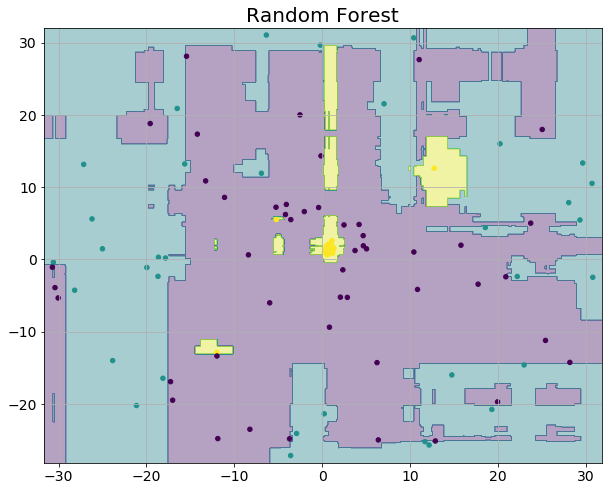

In [54]:
# Plotting decision regions
clf_lr = LogisticRegression( max_iter=1000, C=grid_params['C'], class_weight=grid_params['class_weight'], solver=grid_params['solver'],tol=grid_params['tol'], random_state=random_state)  

#Finding optimal training data size    
pca_num  = 2
trainsize=0.8
rs = random_state

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#Apply PCA
pca = PCA(svd_solver='full', n_components=pca_num, random_state=random_state)
data_train_pca = pca.fit_transform(data_train)
data_test_pca= pca.transform(data_test)
#print(data_test_pca[:10])
pca_time = time.time() 

clf = RandomForestClassifier(random_state=random_state)
clf.fit(data_train_pca, y_train)

pca1_min, pca1_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
pca2_min, pca2_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1

pca1_mesh, pca2_mesh = np.meshgrid(np.arange(pca1_min, pca1_max, 0.1),
                     np.arange(pca2_min, pca2_max, 0.1))

print(np.shape(data_train_pca))
f, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))

#for idx, clf, tt in zip(product([0, 1], [0, 1]),
#                        [clf1, clf2, clf3, eclf],
#                        ['Decision Tree (depth=4)', 'KNN (k=7)',
#                         'Kernel SVM', 'Soft Voting']):

Z = clf.predict(np.c_[pca1_mesh.ravel(), pca2_mesh.ravel()])
Z = Z.reshape(pca1_mesh.shape)

ax.contourf(pca1_mesh, pca2_mesh, Z, alpha=0.4)
ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], c=y_train, s=20)
ax.set_title('Random Forest', fontsize=20)

plt.show()

In [75]:
#Random Forest Optimization with randomizedsearch 


clf_rf = RandomForestClassifier(n_jobs=1, random_state=random_state)
params={'n_estimators':list(np.arange(10,500,20)),'criterion':['gini', 'entropy'],'max_depth':list(np.arange(5,50,2)),\
        'class_weight':['balanced','None'], 'max_features':[pca_num, 0.5, 1, 'sqrt', 'log2']}
verbose=1 

#Finding optimal training data size    
pca_num  = np.array((2,5,10,16,23))
trainsize=0.8
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#standardization_time = time.time() 



print("Randomized Search - Random Forest Classifier")
for pca_comp in pca_num:

    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    #pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    
    #Here we first use randomized search to constraint our parameter space
    rf_random = RandomizedSearchCV(estimator = clf_rf, param_distributions = params, n_iter = 300, cv = 3, verbose=2, random_state=rs, n_jobs = -1)
    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train = search.score(data_train_pca, y_train)
    cv_scores = cross_val_score(search, data_train_pca, y_train, cv=5)
    score_test = search.score(data_test_pca,y_test)
    print("Number of PCA components = {}, RF best parameters = {}".format(pca_comp, search.best_params_))

    print("Classes predicted using {} PCA components by Random Forest = {}".format(pca_comp, le.inverse_transform(clf_class_predictions)))
    
    print("\t Training Score = {:.4g}".format(score_train))
    print("\t CV Score       = {:.4g}".format(cv_scores.mean()))
    print("\t Test Score = {:.4g}".format(score_test))
    
    


  


Randomized Search - Random Forest Classifier
Number of PCA components = 2, RF best parameters = {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.2, 'n_estimators': 40}
Classes predicted using 2 PCA components by Random Forest = ['AlignedSpins' 'NonSpinning' 'Precessing']
	 Training Score = 0.9917
	 CV Score       = 0.7083
	 Test Score = 0.6774
Number of PCA components = 5, RF best parameters = {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.8, 'n_estimators': 20}
Classes predicted using 5 PCA components by Random Forest = ['AlignedSpins' 'NonSpinning' 'Precessing']
	 Training Score = 1
	 CV Score       = 0.8417
	 Test Score = 0.8065
Number of PCA components = 10, RF best parameters = {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.5, 'n_estimators': 40}
Classes predicted using 10 PCA components by Random Forest = ['AlignedSpins' 'NonSpinning' 'Precessing']
	 Training Scor

In [194]:
%%time

#Finding optimal training data size    
pca_num  = np.array((2,5))
trainsize=0.8
rs = random_state

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

print("Training Data after standardization - Mean = {:.4g}, Standard Deviation = {:.4g}".format(data_train.mean(), data_train.std()))
print("Test Data after standardization - Mean = {:.4g}, Standard Deviation = {:.4g} \n\n".format(data_test.mean(), data_test.std()))

print("# PCA Comp    # Classes Predicted \t Train score \t CV score \t Test Score ")
print("-"*100)

score_train, score_test, cv_scores = np.zeros((3, len(pca_num)))

#plt.figure(figsize=(10,6))
for i, pca_comp in enumerate(pca_num[1:]):
    
    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    pca_time = time.time() 
    
    
    #Random Forest with default parameters
    clf1 = RandomForestClassifier(random_state=random_state)
    clf1.fit(data_train_pca, y_train)
    print(clf1.get_params())
    #Compute the cross validation, training and test scores
    score_train = clf1.score(data_train_pca, y_train)
    cv_scores = cross_val_score(clf1, data_train_pca, y_train, cv=5).mean()
    score_test = clf1.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(clf1.predict(data_test_pca))
    
    
    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train, \
                                             cv_scores, score_test))
    
    clf2 = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=5,bootstrap=True,max_features=0.4,\
                                  n_estimators=70,  random_state=random_state)
    clf2.fit(data_train_pca, y_train)
    #print(clf1.get_params())
    #Compute the cross validation, training and test scores
    score_train = clf2.score(data_train_pca, y_train)
    cv_scores = cross_val_score(clf2, data_train_pca, y_train, cv=5).mean()
    score_test = clf2.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(clf2.predict(data_test_pca))
    
    
    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train, \
                                             cv_scores, score_test))
    
    #print("Classes predicted using {} PCA components by Logistic regression = {}".format(pca_comp, le.inverse_transform(clf_class_predictions)))
    #print("Logistic Regression with default settings and 2 PCA components - ")
    #print("\t Training Score = {:.4g}".format(score_train))
    #print("\t CV Score       = {:.4g}".format(cv_scores.mean()))
    #print("\t Test Score = {:.4g}".format(score_test))
    
    



Training Data after standardization - Mean = 1.403e-18, Standard Deviation = 1
Test Data after standardization - Mean = 0.005719, Standard Deviation = 0.9794 


# PCA Comp    # Classes Predicted 	 Train score 	 CV score 	 Test Score 
----------------------------------------------------------------------------------------------------
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 100, 'verbose': 0, 'warm_start': False}
 5 	 	 	 3 		 1 		 0.88 		 0.81
 5 	 	 	 3 		 0.97 		 0.89 		 0.74
CPU times: user 1.44 s, sys: 269 ms, total: 1.71 s
Wall time: 1.14 s


In [196]:
#Random Forest Optimization with gridsearch 


clf = RandomForestClassifier(n_jobs=1, random_state=random_state)
params={'n_estimators':list(np.arange(30,140,30)),'criterion':['gini', 'entropy'],'max_depth':list(np.arange(5,8,1))+[None],\
         'max_features':[0.4,0.6,0.8,0.999], 'class_weight':['balanced','None'], 'bootstrap':[True, False]}
verbose=1 

#Finding optimal training data size    
pca_num  = np.array((2,5,10,15,20,25))
trainsize=0.8
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#standardization_time = time.time() 

score_train, score_test, cv_scores = np.zeros((3, len(pca_num)))

for i, pca_comp in enumerate(pca_num):

    #Apply PCA
    pca = PCA(svd_solver='full', n_components=pca_comp, random_state=random_state)
    data_train_pca = pca.fit_transform(data_train)
    data_test_pca= pca.transform(data_test)
    #pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    
    #Here we search over entire grid of parameters instead of random sampling since our data size is small. For 
    #very large data, RandommizedSearchCV should be preferred. 
    
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)

    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train[i] = search.score(data_train_pca, y_train)
    cv_scores[i] = cross_val_score(search, data_train_pca, y_train, cv=5).mean()
    score_test[i] = search.score(data_test_pca,y_test)
    print("Number of PCA components = {}, LR best parameters = {}".format(pca_comp, search.best_params_))
    print(" %d \t \t \t %d \t\t %.2g \t\t %.2g \t\t %.2g"%(pca_comp, np.size(np.unique(clf_class_predictions)), score_train[i], \
                                             cv_scores[i], score_test[i]))
    
rf_optscores_dict = {'pca':pca_num, 'train_score':score_train, 'cv_score': cv_scores, 'test_score':score_test}

  


Number of PCA components = 2, LR best parameters = {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 0.4, 'n_estimators': 30}
 2 	 	 	 3 		 0.93 		 0.77 		 0.68
Number of PCA components = 5, LR best parameters = {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 0.4, 'n_estimators': 120}
 5 	 	 	 3 		 0.97 		 0.86 		 0.74
Number of PCA components = 10, LR best parameters = {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 0.6, 'n_estimators': 120}
 10 	 	 	 3 		 0.98 		 0.83 		 0.87
Number of PCA components = 15, LR best parameters = {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 0.6, 'n_estimators': 60}
 15 	 	 	 3 		 0.97 		 0.85 		 0.84
Number of PCA components = 20, LR best parameters = {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'max_

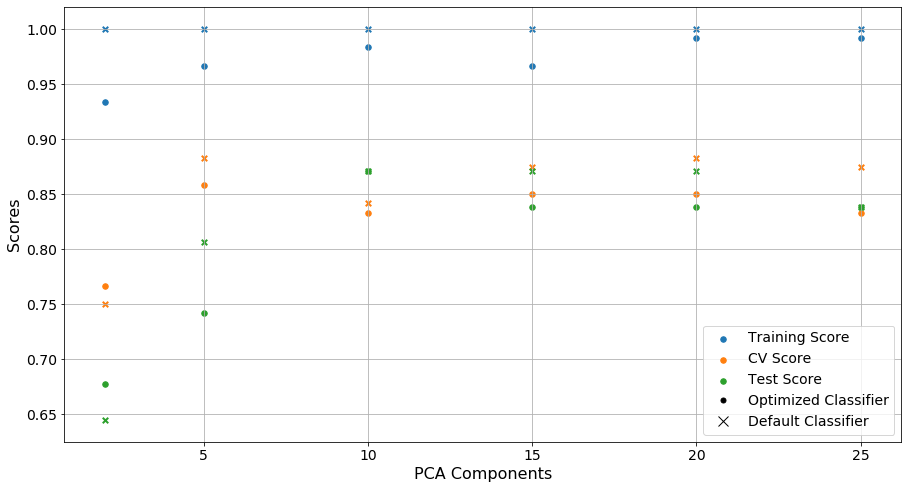

In [198]:
#Plots
plt.figure(figsize=(15,8))

train_plot = plt.scatter(rf_optscores_dict['pca'], rf_optscores_dict['train_score'], marker='o',  s=30, c='C0', label='Training Score')
cv_plot    = plt.scatter(rf_optscores_dict['pca'], rf_optscores_dict['cv_score'], marker='o',  s=30, c='C1', label='CV Score')
test_plot  = plt.scatter(rf_optscores_dict['pca'], rf_optscores_dict['test_score'], marker='o', s=30, c='C2', label='Test Score')

plt.scatter(rf_rawscores_dict['pca'], rf_rawscores_dict['train_score'], marker='x', s=30, c='C0')
plt.scatter(rf_rawscores_dict['pca'], rf_rawscores_dict['cv_score'], marker='x', s=30, c='C1')
plt.scatter(rf_rawscores_dict['pca'], rf_rawscores_dict['test_score'], marker='x', s=30, c='C2')

opt_params = mlines.Line2D([], [], color='k', marker='.', linestyle='None',
                          markersize=10, label='Optimized Classifier')
def_params = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Default Classifier')

plt.xlabel('PCA Components')
plt.ylabel('Scores')
plt.legend(handles = [train_plot, cv_plot, test_plot, opt_params, def_params])
plt.show()
plt.close()
   

In [ ]:
verbose=0
clf = RandomForestClassifier(n_jobs=1, criterion='entropy', n_estimators= 40, max_depth=9, random_state=random_state)
params={}#'n_estimators':[5,10,20,40],'criterion':['gini', 'entropy'],'max_depth':[6,7,8,9]}
n  = np.arange(0.5,0.9,0.05)
params={}

rf_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, show_plot=True)
    

### Classifier : Support Vector Machines (SVM)

__Parameters to play with -__

To optimize SVM classifier, we look at the following parameters - 
* C - Regularization parameter which controls the penalty for each misclassification.
* Weights - Adds weights to each class penalty i.e. C -> w*C or try class_weight='balanced' 
* Kernel - Changes the basis used for projection
* Decision Function shape - fix to 'ovr' - one vs rest (n SVM Classifier build where n is number of classes) 
* Scale data with zero mean and unit variance

To optimize the speed - 
* Check if training data array is C-contiguous and double precision (check flags of np array)
* Set cache size to 500-1000 MB



In [ ]:
%%time

#Finding optimal training data size    
n  = 0.85
pca_num = 2
#rf_orig = ml_classifier(clf, params, waveform_data_ht, y_numeric, n, pca_num, random_state, plot_decisiontree=False, verbose=0,parallelize=False)

#Split data into training and testing
data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#Apply PCA
data_train_pca, pca_train_time = func_PCA(pca_num, data_train, rs)
data_test_pca, pca_test_time = func_PCA(pca_num, data_test, rs)
pca_time = time.time() 

#SVM with default parameters
clf = SVC(random_state=random_state)  
clf.fit(data_train_pca, y_train)

#Compute the cross validation, training and test scores
score_train = clf.score(data_train_pca, y_train)
cv_scores = cross_val_score(clf, data_train_pca, y_train, cv=5)
score_test = clf.score(data_test_pca,y_test)
clf_class_predictions = np.unique(clf.predict(data_test_pca))

print("Classes predicted by Random Forest = {}".format(le.inverse_transform(clf_class_predictions)))
print("Logistic Regression with default settings and 2 PCA components - ")
print("\t Training Score = {:.4g}".format(score_train))
print("\t CV Score       = {:.4g}".format(cv_scores.mean()))
print("\t Test Score = {:.4g}".format(score_test))


# Plotting decision regions

pca1_min, pca1_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
pca2_min, pca2_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1

pca1_mesh, pca2_mesh = np.meshgrid(np.arange(pca1_min, pca1_max, 0.1),
                     np.arange(pca2_min, pca2_max, 0.1))

Z = clf.predict(np.c_[pca1_mesh.ravel(), pca2_mesh.ravel()])
Z = Z.reshape(pca1_mesh.shape)


f, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))

ax.contourf(pca1_mesh, pca2_mesh, Z, alpha=0.4)
ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], c=y_train, s=20, edgecolor='k')
ax.set_title('SVM')

plt.show()


In [ ]:
#Logistic Regression Optimization with gridsearch and PCA components

clf = SVC(decision_function_shape='ovr',cache_size=500, random_state=random_state)  
params={'kernel':['linear','poly', 'rbf', 'sigmoid']}

#params={'C':10.**np.arange(0,2,0.4), 'class_weight':['None', 'balanced'],'kernel':['linear','poly', 'rbf', 'sigmoid'],\
#       'degree':[2,3,4,5], 'gamma':['auto', 'scaled']}
verbose=1 

#Finding optimal training data size    
pca_num  = np.array((2,5,10,40,60))
trainsize=0.85
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

plt.figure(figsize=(15,8))
#standardization_time = time.time() 
for pca_comp in pca_num:

    #Apply PCA
    data_train_pca, pca_train_time = func_PCA(pca_comp, data_train, rs)
    data_test_pca, pca_test_time = func_PCA(pca_comp, data_test, rs)
    pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)

    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train = search.score(data_train_pca, y_train)
    cv_scores = cross_val_score(search, data_train_pca, y_train, cv=5)
    score_test = search.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(search.predict(data_test_pca))

    print("Number of PCA components = {}, LR best parameters = {}".format(pca_comp, search.best_params_))
    print("Classes predicted by Random Forest = {}".format(le.inverse_transform(clf_class_predictions)))
    if pca_comp==pca_num[0]:
        plt.scatter(pca_comp, score_train, c='C0' , label='Training Score')
        plt.scatter(pca_comp, cv_scores.mean(),c='C1', label='CV Score' )
        plt.scatter(pca_comp, score_test, c='C2', label='Testing Score' )
    else:
        plt.scatter(pca_comp, score_train, c='C0' )
        plt.scatter(pca_comp, cv_scores.mean(),c='C1' )
        plt.scatter(pca_comp, score_test, c='C2' )
plt.xlabel('PCA Components')
plt.ylabel('Scores')
plt.legend()
plt.show()
plt.close()
   

In [ ]:
#Logistic Regression Optimization with gridsearch and PCA components

clf = SVC(kernel='rbf',decision_function_shape='ovr',cache_size=500, random_state=random_state)  
#params={'kernel':['linear','poly', 'rbf', 'sigmoid']}

params={'C':10.**np.arange(-2,2.5,0.4), 'class_weight':['None',{0:50, 1:50, 2:1},'balanced'], 'gamma':['auto', 'scaled']}
verbose=1 

#Finding optimal training data size    
pca_num  = np.array((2,5,10,40,60))
trainsize=0.85
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)


plt.figure(figsize=(15,8))
#standardization_time = time.time() 
for pca_comp in pca_num:

    #Apply PCA
    data_train_pca, pca_train_time = func_PCA(pca_comp, data_train, rs)
    data_test_pca, pca_test_time = func_PCA(pca_comp, data_test, rs)
    pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    nprocs=-1
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)

    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train = search.score(data_train_pca, y_train)
    cv_scores = cross_val_score(search, data_train_pca, y_train, cv=5)
    score_test = search.score(data_test_pca,y_test)
    clf_class_predictions = np.unique(search.predict(data_test_pca))

    print("Number of PCA components = {}, LR best parameters = {}".format(pca_comp, search.best_params_))
    print("Classes predicted by SVM = {}".format(le.inverse_transform(clf_class_predictions)))
   
    
    if pca_comp==pca_num[0]:
        plt.scatter(pca_comp, score_train, c='C0' , label='Training Score')
        plt.scatter(pca_comp, cv_scores.mean(),c='C1', label='CV Score' )
        plt.scatter(pca_comp, score_test, c='C2', label='Testing Score' )
    else:
        plt.scatter(pca_comp, score_train, c='C0' )
        plt.scatter(pca_comp, cv_scores.mean(),c='C1' )
        plt.scatter(pca_comp, score_test, c='C2' )
plt.xlabel('PCA Components')
plt.ylabel('Scores')
plt.legend()
plt.show()
plt.close()
   

In [ ]:
w0 = np.size(np.where(y_numeric==0))/np.size(y_numeric)
w1 = np.size(np.where(y_numeric==1))/np.size(y_numeric)
print(w0, w1)

In [ ]:
#Logistic Regression Optimization with gridsearch and PCA components

#Choose weights - 
w0 = np.size(np.where(y_numeric==0))/np.size(y_numeric)
w1 = np.size(np.where(y_numeric==1))/np.size(y_numeric)
clf = SVC(C =1 , kernel='rbf' , class_weight='balanced', gamma='auto', decision_function_shape='ovr',cache_size=500, random_state=random_state)  
verbose=1 

#Finding optimal training data size    
pca_num  =40
trainsize=0.85
rs = random_state


data = np.copy(waveform_data_ht)
y    = np.copy(y_numeric)
data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)

#Standardize the data before applying PCA
SS_data = StandardScaler()
data_train =  SS_data.fit_transform(data_train)
data_test = SS_data.transform(data_test)

#Apply PCA
data_train_pca, pca_train_time = func_PCA(pca_comp, data_train, rs)
data_test_pca, pca_test_time = func_PCA(pca_comp, data_test, rs)
pca_time = time.time() 

#SVM with optimized parameters
#clf = SVC(random_state=random_state)  
clf.fit(data_train_pca, y_train)

#Compute the cross validation, training and test scores
score_train = clf.score(data_train_pca, y_train)
cv_scores = cross_val_score(clf, data_train_pca, y_train, cv=5)
score_test = clf.score(data_test_pca,y_test)
clf_class_predictions = np.unique(clf.predict(data_test_pca))

print("Classes predicted by SVM = {}".format(le.inverse_transform(clf_class_predictions)))
print("Logistic Regression with default settings and 2 PCA components - ")
print("\t Training Score = {:.4g}".format(score_train))
print("\t CV Score       = {:.4g}".format(cv_scores.mean()))
print("\t Test Score = {:.4g}".format(score_test))


## Plotting decision regions
#
#pca1_min, pca1_max = data_train_pca[:, 0].min() - 1, data_train_pca[:, 0].max() + 1
#pca2_min, pca2_max = data_train_pca[:, 1].min() - 1, data_train_pca[:, 1].max() + 1
#
#pca1_mesh, pca2_mesh = np.meshgrid(np.arange(pca1_min, pca1_max, 0.1),
#                     np.arange(pca2_min, pca2_max, 0.1))
#
#Z = clf.predict(np.c_[pca1_mesh.ravel(), pca2_mesh.ravel()])
#Z = Z.reshape(pca1_mesh.shape)
#
#
#f, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))
#
#ax.contourf(pca1_mesh, pca2_mesh, Z, alpha=0.4)
#ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], c=y_train, s=20, edgecolor='k')
#ax.set_title('SVM')
#
#plt.show()
#

###  K-Nearest Neighbours (KNN)

KNN utilizes instance based learning approach by choosing K nearest neighbours and predicting the output using majority vote. SKLearn allows two ways to compute the majority weight - first using uniform weights to all the neighbours and second by assigning the weights based on inverse distance metric. To compute the distance, it again uses two different ways - L1 norm and L2 norm. We search over these three parameters to find the best scores. 

__Parameters__ - 
* n_neighbours - Number of nearest neighbours
* Weight - weight for each neighbour's vote
* p - Distance parameter


__Results__:
* We see that for most training data size vote of small number of nearest neighbours work well. The weight itself can be uniform or weighted by distance from the original point computed using L1 norm. 
* While the training scores are perfect, CV scores are ~85% which is better than most other algorithms. Test scores however are lower ranging from 70-80%.
* This method is also extremely fast compared to few previous methods. 


In [ ]:
%%time
clf = KNeighborsClassifier()
params={'n_neighbors':[1,3,5,7,9,15,20],'weights':['uniform', 'distance'], 'p':[1,2]}
        
rf = {}
verbose=1  

#Finding optimal training data size    
n  = np.arange(0.4,0.9,0.05)

knn = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, show_plot=False)

In [ ]:
%%time
clf = KNeighborsClassifier(n_neighbors=3, weights='distance',p=1)
params={}
verbose=0  

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)

knn_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, show_plot=True)

### Classifier : Naive Bayes

In [ ]:
%%time
clf = GaussianNB()  
params={} 
        
rf = {}
verbose=0 

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)

svm_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, parallelize=True, show_plot=True)


### Classifier : Neural Network

In [ ]:
%%time
clf = MLPClassifier(alpha=0.1, solver='adam', activation='relu', max_iter=1000, random_state=random_state)  
params={ 'hidden_layer_sizes':[10,50,100,200], 'activation':['identity', 'logistic', 'tanh', 'relu']} 

verbose=1 

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.1)
ann = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, parallelize=True, show_plot=True)
